## Data Preprocessing

In [13]:
from pathlib import Path
import pydicom
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [15]:
labels = pd.read_csv('data/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv')
labels.head(6)

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1


In [16]:
labels = labels.drop_duplicates('patientId')
labels.head(6)

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
6,00569f44-917d-4c86-a842-81832af98c30,NaN,NaN,NaN,NaN,0


In [17]:
ROOT_PATH = Path('data/rsna-pneumonia-detection-challenge/stage_2_train_images')
SAVE_PATH = Path('processed/rsna-pneumonia-detection-challenge')

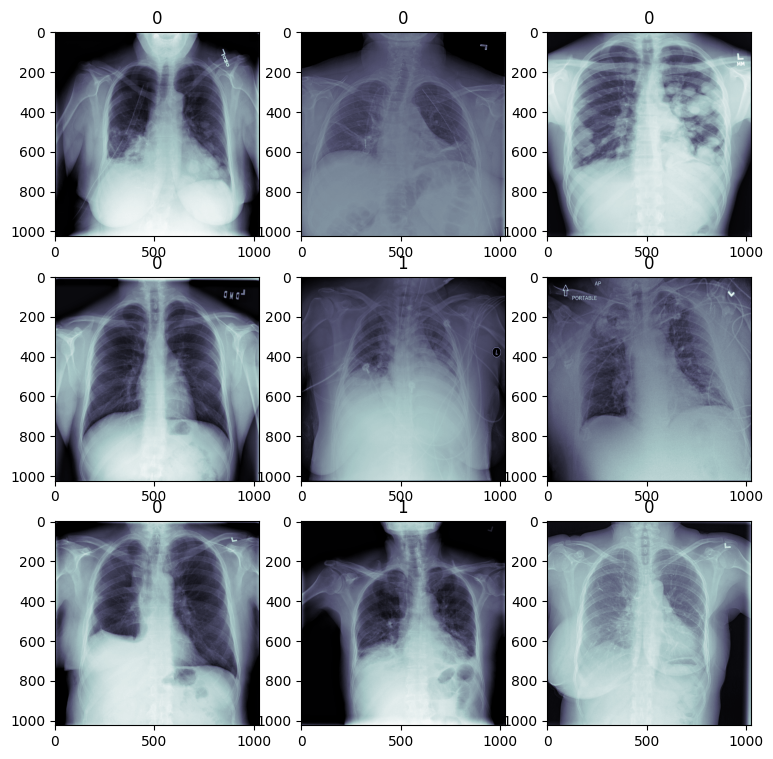

In [18]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(9, 9))
c = 0

for i in range(3):
    for j in range(3):
        patient_id = labels['patientId'].iloc[c]
        dcm_path = ROOT_PATH / patient_id
        dcm_path = dcm_path.with_suffix('.dcm')
        dcm = pydicom.read_file(dcm_path).pixel_array

        label = labels['Target'].iloc[c]

        axes[i][j].imshow(dcm, cmap='bone')
        axes[i][j].set_title(label)
        c += 1

In [19]:
sums, sums_squared = 0, 0

for c, patient_id in enumerate(tqdm(labels['patientId'])):
    patient_id = labels['patientId'].iloc[c]
    dcm_path = ROOT_PATH / patient_id
    dcm_path = dcm_path.with_suffix('.dcm')
    dcm = pydicom.read_file(dcm_path).pixel_array / 255 # Standardization

    dcm_array = cv2.resize(dcm, (244,244)).astype(np.float16)
    label = labels['Target'].iloc[c]

    train_or_val = 'train' if c < 24000 else 'val'

    current_save_path = SAVE_PATH / train_or_val / str(label)
    current_save_path.mkdir(parents=True, exist_ok=True)
    np.save(current_save_path / patient_id, dcm_array)

    normalizer = 224 * 224

    if train_or_val == 'train':
        sums += np.sum(dcm_array) / normalizer
        sums_squared += (dcm_array ** 2).sum() / normalizer

  0%|          | 0/26684 [00:00<?, ?it/s]

In [20]:
# Z-Normalization
mean = sums / 24000
std = np.sqrt((sums_squared / 24000) - mean ** 2)

mean, std

(0.5818625538105833, 0.14044861416019144)

## Data Loading

In [21]:
import torch
import torchvision
from torchvision import transforms, datasets
import torchmetrics
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [22]:
def load_file(path):
    return np.load(path).astype(np.float32)

In [23]:
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
    transforms.RandomAffine(degrees=(-5, 5),
                            translate=(0, 0.05),
                            scale=(0.9, 1.1)),
    transforms.RandomResizedCrop(size=(224, 224),
                                 scale=(0.35, 1),
                                 antialias=True)
])

val_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

In [24]:
train_dataset = datasets.DatasetFolder(root='processed/rsna-pneumonia-detection-challenge/train',
                                       loader=load_file,
                                       extensions='npy',
                                       transform=train_transforms)

val_dataset = datasets.DatasetFolder(root='processed/rsna-pneumonia-detection-challenge/val',
                                     loader=load_file,
                                     extensions='npy',
                                     transform=val_transforms)

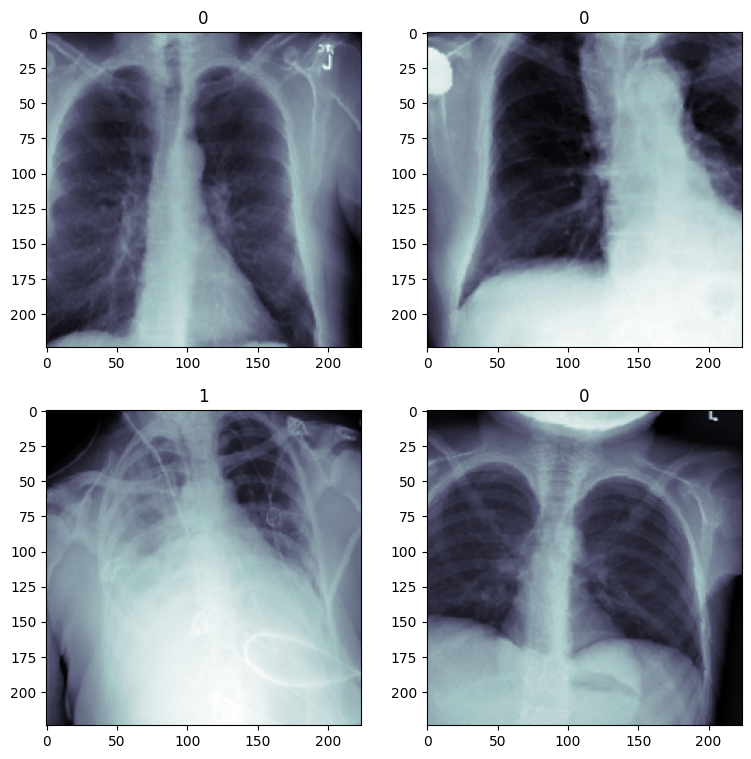

In [25]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 9))

for i in range(2):
    for j in range(2):
        random_index = np.random.randint(0, 24000)
        x_ray, label = train_dataset[random_index]
        axes[i][j].imshow(x_ray[0], cmap='bone')
        axes[i][j].set_title(label)

In [26]:
batch_size = 64
num_workers = 0

train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=batch_size,
                                               num_workers=num_workers,
                                               shuffle=True,
                                               pin_memory=True)

val_dataloader = torch.utils.data.DataLoader(val_dataset,
                                             batch_size=batch_size,
                                             num_workers=num_workers,
                                             shuffle=False,
                                             pin_memory=True)

In [27]:
np.unique(train_dataset.targets, return_counts=True)

(array([0, 1]), array([18593,  5407]))

## Model Creation

In [28]:
torchvision.models.resnet18()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [33]:
class PneumoniaModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = torchvision.models.resnet18()
        self.model.conv1 = torch.nn.Conv2d(in_channels=1,
                                           out_channels=64,
                                           kernel_size=(7, 7),
                                           stride=(2, 2),
                                           padding=(3, 3),
                                           bias=False)
        self.model.fc = torch.nn.Linear(in_features=512,
                                        out_features=1,
                                        bias=True)

        self.optimizer = torch.optim.Adam(params=self.model.parameters(), lr=1e-4)
        self.loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor([3])) # Converting to Weighted BCELoss

        self.train_acc = torchmetrics.Accuracy(task='binary')
        self.val_acc = torchmetrics.Accuracy(task='binary')

    def forward(self, data):
        pred = self.model(data)

        return pred

    def training_step(self, batch, batch_idx):
        x_ray, label = batch
        label = label.float()
        pred = self(x_ray)[:, 0] # As pred shape is (batch_size, 1) while label shape is (batch_size,)
        loss = self.loss_fn(pred, label)

        self.log(name='Train Loss', value=loss)
        self.log(name='Step Train Accuracy', value=self.train_acc(torch.sigmoid(pred), label.int()))

        return loss

    def on_train_epoch_end(self):
        self.log(name='Train Accuracy', value=self.train_acc.compute())

    def validation_step(self, batch, batch_idx):
        x_ray, label = batch
        label = label.float()
        pred = self(x_ray)[:, 0] # As pred shape is (batch_size, 1) while label shape is (batch_size,)
        loss = self.loss_fn(pred, label)

        self.log(name='Validation Loss', value=loss)
        self.log(name='Step Validation Accuracy', value=self.val_acc(torch.sigmoid(pred), label.int()))

    def on_validation_epoch_end(self):
        self.log(name='Validation Accuracy', value=self.val_acc.compute())

    def configure_optimizers(self):
        return [self.optimizer]

In [34]:
model = PneumoniaModel()

checkpoint_callback = ModelCheckpoint(monitor='Validation Accuracy',
                                      save_top_k=10,
                                      mode='max') # Saves checkpoints based on highest accuracy instead of lowest

In [35]:
trainer = pl.Trainer(accelerator='auto',
                     devices='auto',
                     logger=TensorBoardLogger(save_dir='logs'),
                     log_every_n_steps=1,
                     callbacks=checkpoint_callback,
                     max_epochs=35)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [36]:
trainer.fit(model=model,
            train_dataloaders=train_dataloader,
            val_dataloaders=val_dataloader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | model     | ResNet            | 11.2 M | train
1 | loss_fn   | BCEWithLogitsLoss | 0      | train
2 | train_acc | BinaryAccuracy    | 0      | train
3 | val_acc   | BinaryAccuracy    | 0      | train
--------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.683    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=35` reached.


In [42]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = PneumoniaModel.load_from_checkpoint('logs/lightning_logs/version_1/checkpoints/epoch=34-step=13125.ckpt')
model.eval()
model.to(device)

PneumoniaModel(
  (model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

In [43]:
preds = []
labels = []

with torch.inference_mode():
    for data, label in tqdm(val_dataset):
        data = data.to(device).float().unsqueeze(0)
        pred = torch.sigmoid(model(data)[0].cpu())
        preds.append(pred)
        labels.append(label)

preds = torch.tensor(preds)
labels = torch.tensor(labels).int()

  0%|          | 0/2684 [00:00<?, ?it/s]

In [44]:
acc = torchmetrics.Accuracy(task='binary')(preds, labels)
precision = torchmetrics.Precision(task='binary')(preds, labels)
recall = torchmetrics.Recall(task='binary')(preds, labels)
cm = torchmetrics.ConfusionMatrix(task='binary', num_classes=2)(preds, labels)

print(f'Validation Accuracy: {acc}')
print(f'Validation Precision: {precision}')
print(f'Validation Recall: {recall}')
print(f'Confusion Matrix:\n{cm}')

Validation Accuracy: 0.8196721076965332
Validation Precision: 0.5717675089836121
Validation Recall: 0.7966942191123962
Confusion Matrix:
tensor([[1718,  361],
        [ 123,  482]])


## Knowledge Interpretation

In [45]:
import torch
import torchvision
from torchvision import transforms
import pytorch_lightning as pl
import numpy as np
import matplotlib.pyplot as plt

In [46]:
def load_file(path):
    return np.load(path).astype(np.float32)

In [47]:
val_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

val_dataset = datasets.DatasetFolder(root='processed/rsna-pneumonia-detection-challenge/val',
                                     loader=load_file,
                                     extensions='npy',
                                     transform=val_transforms)

In [48]:
temp_model = torchvision.models.resnet18()
temp_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [49]:
list(temp_model.children())[:-2]

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
 Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   )
   (1): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), pad

In [50]:
torch.nn.Sequential(*list(temp_model.children())[:-2])

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [51]:
class PneumoniaModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = torchvision.models.resnet18()
        self.model.conv1 = torch.nn.Conv2d(in_channels=1,
                                           out_channels=64,
                                           kernel_size=(7, 7),
                                           stride=(2, 2),
                                           padding=(3, 3),
                                           bias=False)
        self.model.fc = torch.nn.Linear(in_features=512,
                                        out_features=1,
                                        bias=True)

        self.feature_map = torch.nn.Sequential(*list(self.model.children())[:-2])

    def forward(self, data):
        feature_map = self.feature_map(data)
        avg_pool_output = torch.nn.functional.adaptive_avg_pool2d(input=feature_map,
                                                                  output_size=(1, 1))
        avg_output_flatten = torch.flatten(avg_pool_output)
        pred = self.model.fc(avg_output_flatten)

        return pred, feature_map

In [52]:
model = PneumoniaModel.load_from_checkpoint('logs/lightning_logs/version_1/checkpoints/epoch=34-step=13125.ckpt', strict=False) # As we have changed the model architecture to that of before training
model.eval();

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/core/saving.py:191: Found keys that are in the model state dict but not in the checkpoint: ['feature_map.0.weight', 'feature_map.1.weight', 'feature_map.1.bias', 'feature_map.1.running_mean', 'feature_map.1.running_var', 'feature_map.4.0.conv1.weight', 'feature_map.4.0.bn1.weight', 'feature_map.4.0.bn1.bias', 'feature_map.4.0.bn1.running_mean', 'feature_map.4.0.bn1.running_var', 'feature_map.4.0.conv2.weight', 'feature_map.4.0.bn2.weight', 'feature_map.4.0.bn2.bias', 'feature_map.4.0.bn2.running_mean', 'feature_map.4.0.bn2.running_var', 'feature_map.4.1.conv1.weight', 'feature_map.4.1.bn1.weight', 'feature_map.4.1.bn1.bias', 'feature_map.4.1.bn1.running_mean', 'feature_map.4.1.bn1.running_var', 'feature_map.4.1.conv2.weight', 'feature_map.4.1.bn2.weight', 'feature_map.4.1.bn2.bias', 'feature_map.4.1.bn2.running_mean', 'feature_map.4.1.bn2.running_var', 'feature_map.5.0.conv1.weight', 'feature_map.5.0.bn1.weight', 'feature_map.5.

In [60]:
def cam(model, img):
    with torch.inference_mode():
        pred, features = model(img.unsqueeze(0))

    features = features.reshape((512, -1))
    weight_params = list(model.model.fc.parameters())[0]
    weight = weight_params[0].detach()

    cam = torch.matmul(weight, features)
    cam_img = cam.reshape(8, 8).cpu()

    return cam_img, torch.sigmoid(pred)

In [54]:
def visualize(img, cam, pred):
    img = img[0]
    cam = transforms.functional.resize(cam.unsqueeze(0), (224, 224))[0]

    fig, axes = plt.subplots(nrows=1, ncols=2)
    axes[0].imshow(img, cmap='bone')
    axes[1].imshow(img, cmap='bone')
    axes[1].imshow(cam, alpha=0.5, cmap='jet')
    plt.title(pred > 0.5)

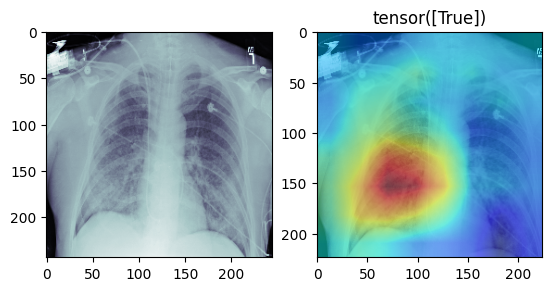

In [62]:
img = val_dataset[-6][0]
activation_map, pred = cam(model.to('cpu'), img)

visualize(img, activation_map, pred)